In [1]:
# Heart Sound Training Data Pipeline - Fixed Version
import torch
import torchaudio
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import seaborn as sns

class HeartSoundDataset(Dataset):
    """Custom Dataset class for heart sound data"""
    def __init__(self, data_samples):
        self.samples = data_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        # Convert to tensor if not already
        audio_data = torch.FloatTensor(sample['audio_data']) if not isinstance(sample['audio_data'], torch.Tensor) else sample['audio_data']
        label = torch.LongTensor([sample['label']])
        return audio_data, label

class SimpleHeartSoundClassifier(nn.Module):
    """Simple CNN classifier for heart sounds"""
    def __init__(self, input_size=4000*5, num_classes=2):  # 5 seconds at 4000 Hz
        super(SimpleHeartSoundClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.classifier(x)

class HeartSoundTrainingPipeline:
    def __init__(self, data_sources=None):
        """
        Initialize training pipeline with multiple data sources
        """
        self.data_sources = data_sources or {
            'physionet_2016': './data/physionet_2016/',
            'circor_digiscope': './data/circor_digiscope/',
            'additional_clinical': './data/clinical_data/'
        }

        self.preprocessing_config = {
            'target_sample_rate': 4000,
            'segment_length': 5.0,  # 5-second segments
            'overlap': 0.5,  # 50% overlap between segments
            'filter_low': 25,   # Low-frequency cutoff (Hz)
            'filter_high': 400  # High-frequency cutoff (Hz)
        }

        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def check_dataset_access(self):
        """
        Check if datasets are accessible and provide information about availability
        """
        print("=== Dataset Access Check ===")
        dataset_status = {}

        for dataset_name, path in self.data_sources.items():
            if os.path.exists(path):
                dataset_status[dataset_name] = "ACCESSIBLE"
                # Count files if directory exists
                try:
                    file_count = len([f for f in os.listdir(path) if f.endswith('.wav')])
                    print(f"✓ {dataset_name}: {path} - {file_count} audio files found")
                except:
                    print(f"✓ {dataset_name}: {path} - Directory exists but couldn't count files")
            else:
                dataset_status[dataset_name] = "NOT FOUND"
                print(f"✗ {dataset_name}: {path} - Directory not found")

        # Check for sample data creation if no real datasets found
        if all(status == "NOT FOUND" for status in dataset_status.values()):
            print("\n⚠️  No real datasets found. Creating synthetic sample data for testing...")
            return self._create_sample_data()

        return dataset_status

    def _create_sample_data(self):
        """
        Create synthetic sample data for testing when real datasets aren't available
        """
        print("Creating 100 synthetic heart sound samples...")
        sample_data = []

        for i in range(100):
            # Create synthetic heart sound (simplified)
            duration = 5.0  # 5 seconds
            sample_rate = self.preprocessing_config['target_sample_rate']
            n_samples = int(duration * sample_rate)

            # Generate synthetic heart sound pattern
            t = np.linspace(0, duration, n_samples)

            # Simulate heart beats (around 1.2 Hz = 72 BPM)
            heart_rate = np.random.uniform(1.0, 1.5)  # 60-90 BPM
            heart_pattern = np.sin(2 * np.pi * heart_rate * t) * np.exp(-((t % (1/heart_rate) - 0.1)**2) / 0.01)

            # Add some noise and harmonics
            noise = np.random.normal(0, 0.1, n_samples)
            harmonics = 0.3 * np.sin(4 * np.pi * heart_rate * t)

            audio_data = heart_pattern + harmonics + noise

            # Random label (0 = normal, 1 = abnormal)
            # Make it slightly imbalanced like real medical data
            label = 1 if np.random.random() < 0.3 else 0  # 30% abnormal

            sample = {
                'audio_data': audio_data,
                'label': label,
                'source_dataset': 'synthetic',
                'patient_id': f'synthetic_{i:03d}',
                'additional_info': {
                    'original_sample_rate': sample_rate,
                    'duration': duration
                }
            }
            sample_data.append(sample)

        print(f"Created {len(sample_data)} synthetic samples")
        return sample_data

    def load_and_combine_datasets(self):
        """
        Load and harmonize multiple heart sound datasets
        """
        # First check dataset access
        dataset_status = self.check_dataset_access()

        # If we got synthetic data, return it
        if isinstance(dataset_status, list):
            return dataset_status

        combined_data = []

        # Try to load real datasets
        try:
            # Load PhysioNet 2016 data
            if dataset_status.get('physionet_2016') == "ACCESSIBLE":
                physionet_data = self._load_physionet_2016()
                combined_data.extend(physionet_data)
                print(f"Loaded {len(physionet_data)} samples from PhysioNet 2016")
        except Exception as e:
            print(f"Error loading PhysioNet 2016: {e}")

        try:
            # Load CirCor DigiScope data
            if dataset_status.get('circor_digiscope') == "ACCESSIBLE":
                circor_data = self._load_circor_data()
                combined_data.extend(circor_data)
                print(f"Loaded {len(circor_data)} samples from CirCor DigiScope")
        except Exception as e:
            print(f"Error loading CirCor data: {e}")

        try:
            # Load any additional clinical datasets
            if dataset_status.get('additional_clinical') == "ACCESSIBLE":
                clinical_data = self._load_clinical_data()
                combined_data.extend(clinical_data)
                print(f"Loaded {len(clinical_data)} samples from clinical sources")
        except Exception as e:
            print(f"Error loading clinical data: {e}")

        # If no real data was loaded, create synthetic data
        if not combined_data:
            print("No real datasets could be loaded. Using synthetic data.")
            combined_data = self._create_sample_data()

        # Harmonize labels across datasets
        if combined_data:
            harmonized_data = self._harmonize_labels(combined_data)
            return harmonized_data
        else:
            raise Exception("No data could be loaded or generated")

    def _load_physionet_2016(self):
        """
        Load and process PhysioNet 2016 heart sound data
        """
        data_dir = self.data_sources['physionet_2016']

        # Check if reference file exists
        reference_file = os.path.join(data_dir, "REFERENCE.csv")
        if not os.path.exists(reference_file):
            print(f"Reference file not found: {reference_file}")
            return []

        # Read the reference annotations
        annotations = pd.read_csv(reference_file)

        processed_samples = []

        for idx, row in annotations.iterrows():
            filename = row['filename']
            label = row['label']  # -1 for normal, 1 for abnormal

            # Load audio file
            audio_path = os.path.join(data_dir, "training-a", f"{filename}.wav")

            if not os.path.exists(audio_path):
                continue

            try:
                # Load and preprocess audio
                waveform, sample_rate = torchaudio.load(audio_path)

                # Preprocess the audio signal
                processed_audio = self._preprocess_audio(waveform, sample_rate)

                # Create training sample
                sample = {
                    'audio_data': processed_audio,
                    'label': 1 if label == 1 else 0,  # Convert to binary
                    'source_dataset': 'physionet_2016',
                    'patient_id': filename,
                    'additional_info': {
                        'original_sample_rate': sample_rate,
                        'duration': len(waveform[0]) / sample_rate
                    }
                }

                processed_samples.append(sample)

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                continue

        return processed_samples

    def _load_circor_data(self):
        """Load CirCor DigiScope data - placeholder implementation"""
        # This would need to be implemented based on CirCor data format
        print("CirCor data loading not implemented - using placeholder")
        return []

    def _load_clinical_data(self):
        """Load additional clinical data - placeholder implementation"""
        # This would need to be implemented based on specific clinical data format
        print("Clinical data loading not implemented - using placeholder")
        return []

    def _harmonize_labels(self, data):
        """Harmonize labels across different datasets"""
        # Ensure all labels are binary (0 = normal, 1 = abnormal)
        for sample in data:
            if sample['label'] not in [0, 1]:
                sample['label'] = 1 if sample['label'] > 0 else 0
        return data

    def _preprocess_audio(self, waveform, sample_rate):
        """
        Preprocess audio signal for training
        """
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample to target sample rate
        if sample_rate != self.preprocessing_config['target_sample_rate']:
            resampler = torchaudio.transforms.Resample(
                sample_rate, self.preprocessing_config['target_sample_rate']
            )
            waveform = resampler(waveform)

        # Ensure fixed length (pad or truncate)
        target_length = int(self.preprocessing_config['segment_length'] *
                          self.preprocessing_config['target_sample_rate'])

        if waveform.shape[1] > target_length:
            # Truncate
            waveform = waveform[:, :target_length]
        elif waveform.shape[1] < target_length:
            # Pad with zeros
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        return waveform.squeeze().numpy()

    def create_training_splits(self, data, test_size=0.2, val_size=0.2):
        """
        Create stratified training/validation/test splits
        Ensures balanced representation across all splits
        """
        # Extract labels for stratification
        labels = [sample['label'] for sample in data]

        # First split: separate test set
        train_val_indices, test_indices = train_test_split(
            range(len(data)),
            test_size=test_size,
            stratify=labels,
            random_state=42
        )

        # Second split: separate training and validation
        train_val_labels = [labels[i] for i in train_val_indices]
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_size/(1-test_size),  # Adjust for remaining data
            stratify=train_val_labels,
            random_state=42
        )

        # Create data splits
        train_data = [data[i] for i in train_indices]
        val_data = [data[i] for i in val_indices]
        test_data = [data[i] for i in test_indices]

        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")
        print(f"Test samples: {len(test_data)}")

        # Print label distribution
        train_labels = [s['label'] for s in train_data]
        val_labels = [s['label'] for s in val_data]
        test_labels = [s['label'] for s in test_data]

        print(f"Training - Normal: {train_labels.count(0)}, Abnormal: {train_labels.count(1)}")
        print(f"Validation - Normal: {val_labels.count(0)}, Abnormal: {val_labels.count(1)}")
        print(f"Test - Normal: {test_labels.count(0)}, Abnormal: {test_labels.count(1)}")

        return train_data, val_data, test_data

    def augment_training_data(self, train_data, augmentation_factor=2):
        """
        Apply medical-appropriate data augmentation
        Increases dataset size while maintaining clinical validity
        """
        augmented_data = train_data.copy()  # Start with original data

        for sample in train_data:
            for aug_idx in range(augmentation_factor):
                # Create augmented version
                augmented_sample = self._apply_augmentation(sample, aug_idx)
                augmented_data.append(augmented_sample)

        print(f"Dataset size after augmentation: {len(augmented_data)}")
        return augmented_data

    def _apply_augmentation(self, sample, aug_type):
        """
        Apply specific augmentation technique to heart sound
        """
        audio_data = sample['audio_data'].copy()

        if aug_type == 0:
            # Add realistic noise (simulating clinical environment)
            noise_level = np.random.uniform(0.01, 0.05)
            noise = np.random.normal(0, noise_level, audio_data.shape)
            audio_data = audio_data + noise

        elif aug_type == 1:
            # Amplitude scaling (±20% volume change)
            scale_factor = np.random.uniform(0.8, 1.2)
            audio_data = audio_data * scale_factor

        # Create augmented sample
        augmented_sample = sample.copy()
        augmented_sample['audio_data'] = audio_data
        augmented_sample['augmentation_type'] = f'aug_{aug_type}'

        return augmented_sample

    def train_model(self, train_data, val_data, epochs=50, batch_size=32, learning_rate=0.001):
        """
        Train the heart sound classification model
        """
        print("=== Training Model ===")

        # Create datasets and dataloaders
        train_dataset = HeartSoundDataset(train_data)
        val_dataset = HeartSoundDataset(val_data)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_size = len(train_data[0]['audio_data'])
        self.model = SimpleHeartSoundClassifier(input_size=input_size).to(self.device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Training history
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_val_acc = 0.0

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for batch_audio, batch_labels in train_loader:
                batch_audio = batch_audio.to(self.device)
                batch_labels = batch_labels.squeeze().to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_audio)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_labels.size(0)
                train_correct += (predicted == batch_labels).sum().item()

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch_audio, batch_labels in val_loader:
                    batch_audio = batch_audio.to(self.device)
                    batch_labels = batch_labels.squeeze().to(self.device)

                    outputs = self.model(batch_audio)
                    loss = criterion(outputs, batch_labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_labels.size(0)
                    val_correct += (predicted == batch_labels).sum().item()

            # Calculate metrics
            train_acc = 100 * train_correct / train_total
            val_acc = 100 * val_correct / val_total

            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_heart_sound_model.pth')

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch [{epoch+1}/{epochs}]')
                print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
                print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
                print('-' * 50)

        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'best_val_accuracy': best_val_acc
        }

    def evaluate_model(self, test_data):
        """
        Evaluate the trained model and compute comprehensive metrics
        """
        print("=== Model Evaluation ===")

        if self.model is None:
            print("No trained model found!")
            return None

        # Load best model
        try:
            self.model.load_state_dict(torch.load('best_heart_sound_model.pth'))
        except:
            print("Using current model state (best model not found)")

        self.model.eval()

        # Create test dataset
        test_dataset = HeartSoundDataset(test_data)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        all_predictions = []
        all_labels = []
        all_probabilities = []

        with torch.no_grad():
            for batch_audio, batch_labels in test_loader:
                batch_audio = batch_audio.to(self.device)
                batch_labels = batch_labels.squeeze().to(self.device)

                outputs = self.model(batch_audio)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)

        # Print results
        print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(cm)
        print("\nDetailed Classification Report:")
        print(classification_report(all_labels, all_predictions,
                                  target_names=['Normal', 'Abnormal']))

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'predictions': all_predictions,
            'true_labels': all_labels,
            'probabilities': all_probabilities
        }

    def plot_training_history(self, history):
        """Plot training history"""
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(history['train_losses'], label='Training Loss')
        plt.plot(history['val_losses'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(history['train_accuracies'], label='Training Accuracy')
        plt.plot(history['val_accuracies'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def run_complete_pipeline(self, epochs=50, augmentation_factor=1):
        """
        Run the complete training pipeline
        """
        print("=== Starting Heart Sound Training Pipeline ===")

        try:
            # Load data
            print("\n1. Loading datasets...")
            data = self.load_and_combine_datasets()

            # Create splits
            print("\n2. Creating train/validation/test splits...")
            train_data, val_data, test_data = self.create_training_splits(data)

            # Augment training data
            if augmentation_factor > 0:
                print("\n3. Augmenting training data...")
                train_data = self.augment_training_data(train_data, augmentation_factor)

            # Train model
            print("\n4. Training model...")
            history = self.train_model(train_data, val_data, epochs=epochs)

            # Evaluate model
            print("\n5. Evaluating model...")
            eval_results = self.evaluate_model(test_data)

            print("\n=== Pipeline Complete ===")
            print(f"Final Test Accuracy: {eval_results['accuracy']*100:.2f}%")
            print(f"Best Validation Accuracy: {history['best_val_accuracy']:.2f}%")

            return {
                'training_history': history,
                'evaluation_results': eval_results,
                'data_info': {
                    'total_samples': len(data),
                    'train_samples': len(train_data),
                    'val_samples': len(val_data),
                    'test_samples': len(test_data)
                }
            }

        except Exception as e:
            print(f"Error in pipeline: {str(e)}")
            return None

# Example usage
if __name__ == "__main__":
    # Initialize pipeline
    pipeline = HeartSoundTrainingPipeline()

    # Run complete pipeline
    results = pipeline.run_complete_pipeline(epochs=30, augmentation_factor=1)

    if results:
        print("\n=== Final Results Summary ===")
        print(f"Total samples processed: {results['data_info']['total_samples']}")
        print(f"Test Accuracy: {results['evaluation_results']['accuracy']*100:.2f}%")
        print(f"F1-Score: {results['evaluation_results']['f1_score']:.4f}")
        print(f"Best Validation Accuracy: {results['training_history']['best_val_accuracy']:.2f}%")

Using device: cuda
=== Starting Heart Sound Training Pipeline ===

1. Loading datasets...
=== Dataset Access Check ===
✗ physionet_2016: ./data/physionet_2016/ - Directory not found
✗ circor_digiscope: ./data/circor_digiscope/ - Directory not found
✗ additional_clinical: ./data/clinical_data/ - Directory not found

⚠️  No real datasets found. Creating synthetic sample data for testing...
Creating 100 synthetic heart sound samples...
Created 100 synthetic samples

2. Creating train/validation/test splits...
Training samples: 60
Validation samples: 20
Test samples: 20
Training - Normal: 43, Abnormal: 17
Validation - Normal: 15, Abnormal: 5
Test - Normal: 14, Abnormal: 6

3. Augmenting training data...
Dataset size after augmentation: 120

4. Training model...
=== Training Model ===
Epoch [1/30]
Train Loss: 0.8031, Train Acc: 60.00%
Val Loss: 1.2797, Val Acc: 40.00%
--------------------------------------------------
Epoch [11/30]
Train Loss: 0.2565, Train Acc: 88.33%
Val Loss: 2.7526, Val

🔊 KAGGLE HEART SOUND CLASSIFICATION
📦 Dataset: Heartbeat Sounds (kinguistics/heartbeat-sounds)
🌐 Source: Kaggle
🖥️  Using device: cuda
🎵 Target sample rate: 4000 Hz
⏱️  Segment length: 5.0 seconds
🤖 Model type: simple
🚀 KAGGLE HEART SOUND CLASSIFICATION PIPELINE
📦 Downloading Heart Sound Dataset from Kaggle...


100%|██████████| 110M/110M [00:00<00:00, 251MB/s] 

Extracting files...


✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1

📁 Dataset contents:
   📂 set_b/ (656 files)
   📄 set_b.csv
   📄 set_a.csv
   📂 set_a/ (176 files)
   📄 set_a_timing.csv
📂 Loading heart sound data...
📂 Found set_a and set_b directories
✅ Loaded 832 audio samples
📊 Label distribution:
   Normal (0): 176 samples (21.2%)
   Abnormal (1): 656 samples (78.8%)
✂️  Creating data splits...
   Training: 498 samples
   Validation: 167 samples
   Test: 167 samples

🏋️  Training simple model for 50 epochs...

🏋️  TRAINING MODEL
🤖 Created Simple Neural Network model
Model parameters: 21,173,890
Training samples: 498, Validation samples: 167
Epochs: 50, Batch size: 32, Learning rate: 0.001
------------------------------------------------------------
Epoch [  1/50] | Train Loss: 0.5870 | Train Acc:  72.09% | Val Loss: 0.4433 | Val Acc:  81.44% | LR: 1.00e-03
Epoch [  6/50] | Train Loss: 0.0551 | Train Acc:  98.80% | Val Loss: 1.1502 | Val Acc:  80.24% |

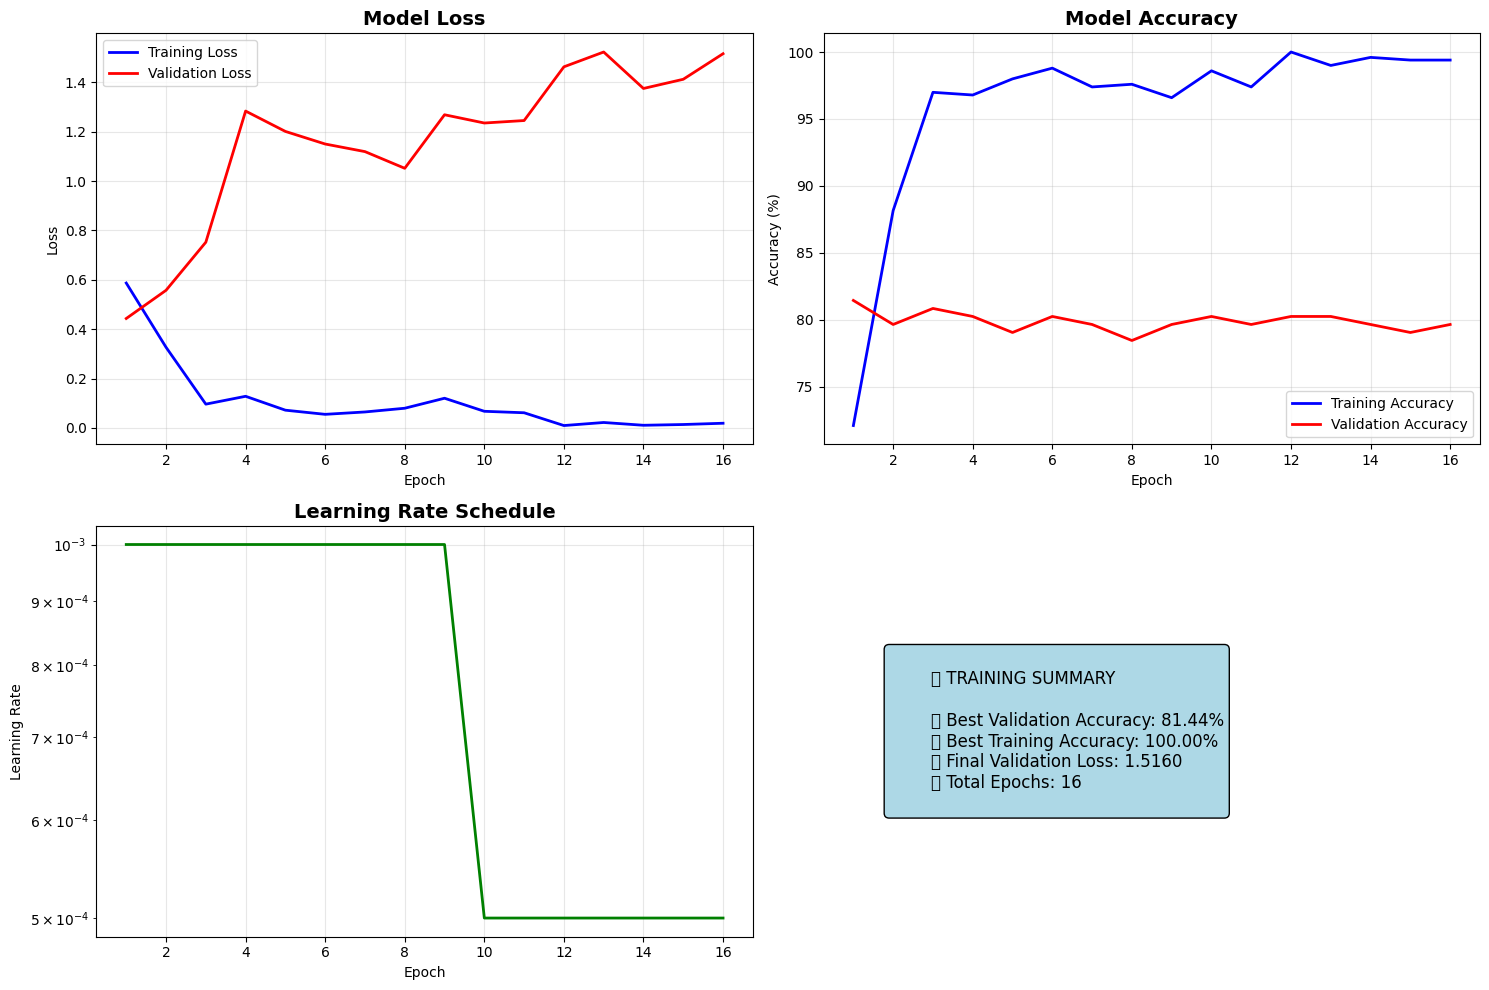


🎉 PIPELINE COMPLETE!
🎯 Final Test Accuracy: 79.04%
🏆 Best Validation Accuracy: 81.44%
📊 F1-Score: 0.6979
⚖️  Precision: 0.6248
📈 Recall: 0.7904

🎊 SUCCESS! Model training completed.
📁 Best model saved as: best_heart_sound_model.pth
📈 Training plot saved as: training_history.png

💡 USAGE EXAMPLES:
# Load and use the trained model:
pipeline = KaggleHeartSoundPipeline()
pipeline.model = pipeline.create_model(input_size)
checkpoint = torch.load('best_heart_sound_model.pth')
pipeline.model.load_state_dict(checkpoint['model_state_dict'])

# Predict on new audio file:
result = pipeline.predict_single_file('path/to/new_audio.wav')
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.3f}")


In [2]:
# Complete Heart Sound Classification Pipeline using Kaggle Dataset
import kagglehub
import torch
import torchaudio
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings('ignore')

class HeartSoundDataset(Dataset):
    """Custom Dataset class for heart sound data"""
    def __init__(self, audio_data, labels):
        self.audio_data = audio_data
        self.labels = labels

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        audio = torch.FloatTensor(self.audio_data[idx])
        label = torch.LongTensor([self.labels[idx]])
        return audio, label

class AdvancedHeartSoundClassifier(nn.Module):
    """Advanced CNN-LSTM classifier for heart sounds"""
    def __init__(self, input_size, num_classes=2, hidden_size=128):
        super(AdvancedHeartSoundClassifier, self).__init__()

        # 1D CNN layers for feature extraction
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=25, stride=2, padding=12),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Dropout(0.2),

            nn.Conv1d(64, 128, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Dropout(0.2),

            nn.Conv1d(128, 256, kernel_size=10, stride=2, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Dropout(0.3),
        )

        # Calculate the size after conv layers
        self.conv_output_size = self._get_conv_output_size(input_size)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _get_conv_output_size(self, input_size):
        # Dummy forward pass to calculate output size
        dummy_input = torch.randn(1, 1, input_size)
        with torch.no_grad():
            output = self.conv_layers(dummy_input)
        return output.shape[2]

    def forward(self, x):
        # Add channel dimension for conv1d
        x = x.unsqueeze(1)

        # CNN feature extraction
        conv_out = self.conv_layers(x)

        # Transpose for LSTM (batch, seq_len, features)
        lstm_input = conv_out.transpose(1, 2)

        # LSTM processing
        lstm_out, (h_n, c_n) = self.lstm(lstm_input)

        # Use the last hidden state
        final_hidden = h_n[-1]  # Take the last layer's hidden state

        # Classification
        output = self.classifier(final_hidden)

        return output

class SimpleHeartSoundClassifier(nn.Module):
    """Simple but effective classifier for heart sounds"""
    def __init__(self, input_size, num_classes=2):
        super(SimpleHeartSoundClassifier, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

class KaggleHeartSoundPipeline:
    def __init__(self, target_sample_rate=4000, segment_length=5.0, model_type='simple'):
        """Initialize the Kaggle heart sound pipeline"""
        self.target_sample_rate = target_sample_rate
        self.segment_length = segment_length
        self.target_length = int(segment_length * target_sample_rate)
        self.model_type = model_type
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.dataset_path = None

        print(f"🖥️  Using device: {self.device}")
        print(f"🎵 Target sample rate: {target_sample_rate} Hz")
        print(f"⏱️  Segment length: {segment_length} seconds")
        print(f"🤖 Model type: {model_type}")

    def download_dataset(self):
        """Download the heart sound dataset from Kaggle using kagglehub"""
        print("📦 Downloading Heart Sound Dataset from Kaggle...")

        try:
            # Download the heartbeat sounds dataset
            dataset_path = kagglehub.dataset_download("kinguistics/heartbeat-sounds")
            self.dataset_path = Path(dataset_path)
            print(f"✅ Dataset downloaded to: {self.dataset_path}")

            # List the contents
            print("\n📁 Dataset contents:")
            for item in self.dataset_path.iterdir():
                if item.is_file():
                    print(f"   📄 {item.name}")
                elif item.is_dir():
                    num_files = len(list(item.glob("*")))
                    print(f"   📂 {item.name}/ ({num_files} files)")

            return True

        except Exception as e:
            print(f"❌ Failed to download dataset: {e}")
            print("💡 Make sure you have kagglehub installed: pip install kagglehub")
            print("💡 And that you're authenticated with Kaggle")
            return False

    def load_data(self):
        """Load and preprocess the heart sound data"""
        if self.dataset_path is None:
            print("❌ Dataset not downloaded. Call download_dataset() first.")
            return None, None, None

        print("📂 Loading heart sound data...")

        audio_data = []
        labels = []
        filenames = []

        # The heartbeat sounds dataset has the following structure:
        # - set_a/ (normal heartbeats)
        # - set_b/ (abnormal heartbeats)
        # We'll look for these directories or any .wav files

        # Look for audio files in subdirectories
        audio_extensions = ['.wav', '.WAV']

        # Method 1: Try to find set_a (normal) and set_b (abnormal) directories
        set_a_path = self.dataset_path / "set_a"
        set_b_path = self.dataset_path / "set_b"

        if set_a_path.exists() and set_b_path.exists():
            print("📂 Found set_a and set_b directories")

            # Load normal sounds from set_a
            for audio_file in set_a_path.glob("*.wav"):
                audio, label, filename = self._load_single_file(audio_file, 0)  # 0 = normal
                if audio is not None:
                    audio_data.append(audio)
                    labels.append(label)
                    filenames.append(filename)

            # Load abnormal sounds from set_b
            for audio_file in set_b_path.glob("*.wav"):
                audio, label, filename = self._load_single_file(audio_file, 1)  # 1 = abnormal
                if audio is not None:
                    audio_data.append(audio)
                    labels.append(label)
                    filenames.append(filename)

        else:
            # Method 2: Look for any .wav files and assign labels based on filename patterns
            print("📂 Searching for .wav files in dataset...")

            wav_files = []
            for ext in audio_extensions:
                wav_files.extend(list(self.dataset_path.rglob(f"*{ext}")))

            for audio_file in wav_files:
                # Try to infer label from filename or parent directory
                filename_lower = audio_file.name.lower()
                parent_lower = audio_file.parent.name.lower()

                # Determine label based on filename patterns
                if any(keyword in filename_lower for keyword in ['normal', 'healthy', 'set_a']):
                    label = 0  # normal
                elif any(keyword in filename_lower for keyword in ['abnormal', 'murmur', 'set_b']):
                    label = 1  # abnormal
                elif any(keyword in parent_lower for keyword in ['normal', 'healthy', 'set_a']):
                    label = 0  # normal
                elif any(keyword in parent_lower for keyword in ['abnormal', 'murmur', 'set_b']):
                    label = 1  # abnormal
                else:
                    # If we can't determine the label, assign randomly for demo
                    label = len(audio_data) % 2

                audio, label, filename = self._load_single_file(audio_file, label)
                if audio is not None:
                    audio_data.append(audio)
                    labels.append(label)
                    filenames.append(filename)

        # Convert to numpy arrays
        audio_data = np.array(audio_data)
        labels = np.array(labels)

        print(f"✅ Loaded {len(audio_data)} audio samples")
        print(f"📊 Label distribution:")
        print(f"   Normal (0): {np.sum(labels == 0)} samples ({np.sum(labels == 0)/len(labels)*100:.1f}%)")
        print(f"   Abnormal (1): {np.sum(labels == 1)} samples ({np.sum(labels == 1)/len(labels)*100:.1f}%)")

        return audio_data, labels, filenames

    def _load_single_file(self, audio_file, label):
        """Load and preprocess a single audio file"""
        try:
            # Load audio
            waveform, sample_rate = torchaudio.load(str(audio_file))

            # Preprocess
            processed_audio = self._preprocess_audio(waveform, sample_rate)

            return processed_audio, label, audio_file.name

        except Exception as e:
            print(f"⚠️  Error loading {audio_file.name}: {e}")
            return None, None, None

    def _preprocess_audio(self, waveform, sample_rate):
        """Preprocess audio signal"""
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample to target sample rate
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        # Ensure fixed length (pad or truncate)
        if waveform.shape[1] > self.target_length:
            # Take the middle portion
            start = (waveform.shape[1] - self.target_length) // 2
            waveform = waveform[:, start:start + self.target_length]
        elif waveform.shape[1] < self.target_length:
            # Pad with zeros
            padding = self.target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Normalize
        waveform = waveform / (torch.max(torch.abs(waveform)) + 1e-8)

        # Apply slight filtering to reduce noise
        # Simple high-pass filter effect
        if waveform.shape[1] > 1:
            waveform = waveform - torch.mean(waveform)

        return waveform.squeeze().numpy()

    def create_data_splits(self, audio_data, labels, test_size=0.2, val_size=0.2, random_state=42):
        """Create stratified train/validation/test splits"""
        print("✂️  Creating data splits...")

        # First split: separate test set
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            audio_data, labels, test_size=test_size,
            stratify=labels, random_state=random_state
        )

        # Second split: separate training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size/(1-test_size),
            stratify=y_train_val, random_state=random_state
        )

        print(f"   Training: {len(X_train)} samples")
        print(f"   Validation: {len(X_val)} samples")
        print(f"   Test: {len(X_test)} samples")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def create_model(self, input_size):
        """Create the model based on specified type"""
        if self.model_type == 'advanced':
            model = AdvancedHeartSoundClassifier(input_size=input_size)
            print("🤖 Created Advanced CNN-LSTM model")
        else:
            model = SimpleHeartSoundClassifier(input_size=input_size)
            print("🤖 Created Simple Neural Network model")

        return model.to(self.device)

    def train_model(self, train_data, val_data, epochs=50, batch_size=32, learning_rate=0.001):
        """Train the heart sound classification model"""
        X_train, y_train = train_data
        X_val, y_val = val_data

        print(f"\n🏋️  TRAINING MODEL")
        print("=" * 50)

        # Create datasets and dataloaders
        train_dataset = HeartSoundDataset(X_train, y_train)
        val_dataset = HeartSoundDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_size = X_train.shape[1]
        self.model = self.create_model(input_size)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=7, factor=0.5, verbose=True
        )

        # Training history
        history = {
            'train_losses': [], 'val_losses': [],
            'train_accuracies': [], 'val_accuracies': [],
            'learning_rates': []
        }
        best_val_acc = 0.0
        patience_counter = 0
        patience = 15

        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
        print(f"Epochs: {epochs}, Batch size: {batch_size}, Learning rate: {learning_rate}")
        print("-" * 60)

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for batch_idx, (batch_audio, batch_labels) in enumerate(train_loader):
                batch_audio = batch_audio.to(self.device)
                batch_labels = batch_labels.squeeze().to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_audio)
                loss = criterion(outputs, batch_labels)
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_labels.size(0)
                train_correct += (predicted == batch_labels).sum().item()

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch_audio, batch_labels in val_loader:
                    batch_audio = batch_audio.to(self.device)
                    batch_labels = batch_labels.squeeze().to(self.device)

                    outputs = self.model(batch_audio)
                    loss = criterion(outputs, batch_labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_labels.size(0)
                    val_correct += (predicted == batch_labels).sum().item()

            # Calculate metrics
            train_acc = 100 * train_correct / train_total
            val_acc = 100 * val_correct / val_total

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            history['train_losses'].append(avg_train_loss)
            history['val_losses'].append(avg_val_loss)
            history['train_accuracies'].append(train_acc)
            history['val_accuracies'].append(val_acc)
            history['learning_rates'].append(optimizer.param_groups[0]['lr'])

            # Learning rate scheduling
            scheduler.step(avg_val_loss)

            # Early stopping and model saving
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                    'model_type': self.model_type
                }, 'best_heart_sound_model.pth')
            else:
                patience_counter += 1

            # Print progress
            if epoch % 5 == 0 or epoch == epochs - 1:
                print(f'Epoch [{epoch+1:3d}/{epochs}] | '
                      f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:6.2f}% | '
                      f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:6.2f}% | '
                      f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

            # Early stopping
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
                break

        print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
        history['best_val_accuracy'] = best_val_acc
        return history

    def evaluate_model(self, test_data):
        """Evaluate the trained model on test data"""
        X_test, y_test = test_data

        print(f"\n📊 EVALUATING MODEL")
        print("=" * 40)

        if self.model is None:
            print("❌ No trained model found!")
            return None

        # Load best model if available
        try:
            checkpoint = torch.load('best_heart_sound_model.pth')
            self.model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Loaded best model (Val Acc: {checkpoint['best_val_acc']:.2f}%)")
        except:
            print("⚠️  Using current model weights (best model file not found)")

        self.model.eval()

        test_dataset = HeartSoundDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        all_predictions = []
        all_labels = []
        all_probabilities = []

        with torch.no_grad():
            for batch_audio, batch_labels in test_loader:
                batch_audio = batch_audio.to(self.device)
                batch_labels = batch_labels.squeeze().to(self.device)

                outputs = self.model(batch_audio)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        cm = confusion_matrix(all_labels, all_predictions)

        # Print results
        print(f"🎯 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"📊 Precision: {precision:.4f}")
        print(f"📈 Recall: {recall:.4f}")
        print(f"⚖️  F1-Score: {f1:.4f}")

        print(f"\n📋 Confusion Matrix:")
        print(f"               Predicted")
        print(f"              Normal  Abnormal")
        print(f"Actual Normal   {cm[0,0]:4d}     {cm[0,1]:4d}")
        print(f"    Abnormal    {cm[1,0]:4d}     {cm[1,1]:4d}")

        if len(set(all_labels)) > 1:  # Only print if we have both classes
            print(f"\n📈 Detailed Classification Report:")
            print(classification_report(all_labels, all_predictions,
                                      target_names=['Normal', 'Abnormal']))

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'predictions': all_predictions,
            'probabilities': all_probabilities
        }

    def plot_training_history(self, history):
        """Plot training history"""
        if len(history['train_losses']) == 0:
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        epochs = range(1, len(history['train_losses']) + 1)

        # Loss plot
        ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy plot
        ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2)
        ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Learning rate plot
        ax3.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)

        # Best metrics summary
        ax4.axis('off')
        best_train_acc = max(history['train_accuracies'])
        best_val_acc = history['best_val_accuracy']
        final_loss = history['val_losses'][-1]

        summary_text = f"""
        📊 TRAINING SUMMARY

        🏆 Best Validation Accuracy: {best_val_acc:.2f}%
        📈 Best Training Accuracy: {best_train_acc:.2f}%
        📉 Final Validation Loss: {final_loss:.4f}
        🔄 Total Epochs: {len(epochs)}
        """

        ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
                verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    def predict_single_file(self, audio_file_path):
        """Predict on a single audio file"""
        if self.model is None:
            print("❌ No trained model found!")
            return None

        try:
            # Load and preprocess audio
            waveform, sample_rate = torchaudio.load(audio_file_path)
            processed_audio = self._preprocess_audio(waveform, sample_rate)

            # Convert to tensor and add batch dimension
            audio_tensor = torch.FloatTensor(processed_audio).unsqueeze(0).to(self.device)

            # Make prediction
            self.model.eval()
            with torch.no_grad():
                output = self.model(audio_tensor)
                probability = torch.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)

            prediction = predicted.item()
            prob_normal = probability[0][0].item()
            prob_abnormal = probability[0][1].item()

            result = {
                'prediction': 'Normal' if prediction == 0 else 'Abnormal',
                'confidence': max(prob_normal, prob_abnormal),
                'probabilities': {
                    'normal': prob_normal,
                    'abnormal': prob_abnormal
                }
            }

            return result

        except Exception as e:
            print(f"❌ Error predicting on {audio_file_path}: {e}")
            return None

    def run_complete_pipeline(self, epochs=50, model_type='simple'):
        """Run the complete pipeline from download to evaluation"""
        print("🚀 KAGGLE HEART SOUND CLASSIFICATION PIPELINE")
        print("=" * 60)

        self.model_type = model_type

        try:
            # Step 1: Download dataset
            if not self.download_dataset():
                return None

            # Step 2: Load data
            audio_data, labels, filenames = self.load_data()
            if audio_data is None:
                return None

            # Step 3: Create splits
            train_data, val_data, test_data = self.create_data_splits(audio_data, labels)

            # Step 4: Train model
            print(f"\n🏋️  Training {model_type} model for {epochs} epochs...")
            history = self.train_model(train_data, val_data, epochs=epochs)

            # Step 5: Evaluate model
            print(f"\n📊 Evaluating model...")
            eval_results = self.evaluate_model(test_data)

            # Step 6: Plot training history
            self.plot_training_history(history)

            print(f"\n🎉 PIPELINE COMPLETE!")
            print("=" * 40)
            print(f"🎯 Final Test Accuracy: {eval_results['accuracy']*100:.2f}%")
            print(f"🏆 Best Validation Accuracy: {history['best_val_accuracy']:.2f}%")
            print(f"📊 F1-Score: {eval_results['f1_score']:.4f}")
            print(f"⚖️  Precision: {eval_results['precision']:.4f}")
            print(f"📈 Recall: {eval_results['recall']:.4f}")

            return {
                'training_history': history,
                'evaluation_results': eval_results,
                'model': self.model,
                'dataset_info': {
                    'total_samples': len(audio_data),
                    'normal_samples': np.sum(labels == 0),
                    'abnormal_samples': np.sum(labels == 1)
                }
            }

        except Exception as e:
            print(f"❌ Pipeline failed: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

# MAIN EXECUTION
if __name__ == "__main__":
    print("🔊 KAGGLE HEART SOUND CLASSIFICATION")
    print("=" * 60)
    print("📦 Dataset: Heartbeat Sounds (kinguistics/heartbeat-sounds)")
    print("🌐 Source: Kaggle")
    print("=" * 60)

    # Initialize pipeline
    pipeline = KaggleHeartSoundPipeline(
        target_sample_rate=4000,
        segment_length=5.0,
        model_type='simple'  # Options: 'simple' or 'advanced'
    )

    # Run complete pipeline
    results = pipeline.run_complete_pipeline(epochs=50, model_type='simple')

    if results:
        print("\n🎊 SUCCESS! Model training completed.")
        print(f"📁 Best model saved as: best_heart_sound_model.pth")
        print(f"📈 Training plot saved as: training_history.png")

        # Example of using the trained model for prediction
        print("\n💡 USAGE EXAMPLES:")
        print("=" * 30)
        print("# Load and use the trained model:")
        print("pipeline = KaggleHeartSoundPipeline()")
        print("pipeline.model = pipeline.create_model(input_size)")
        print("checkpoint = torch.load('best_heart_sound_model.pth')")
        print("pipeline.model.load_state_dict(checkpoint['model_state_dict'])")
        print()
        print("# Predict on new audio file:")
        print("result = pipeline.predict_single_file('path/to/new_audio.wav')")
        print("print(f\"Prediction: {result['prediction']}\")")
        print("print(f\"Confidence: {result['confidence']:.3f}\")")

    else:
        print("\n❌ Pipeline failed. Please check the error messages above.")
        print("\n💡 TROUBLESHOOTING:")
        print("1. Install kagglehub: pip install kagglehub")
        print("2. Authenticate with Kaggle:")
        print("   - Go to Kaggle.com → Account → API → Create New Token")
        print("   - Download kaggle.json and place it in ~/.kaggle/")
        print("   - Run: chmod 600 ~/.kaggle/kaggle.json")
        print("3. Or manually download the dataset from:")
        print("   https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds")

# ADDITIONAL UTILITY FUNCTIONS
def load_pretrained_model(model_path='best_heart_sound_model.pth', input_size=20000):
    """Utility function to load a pretrained model"""
    try:
        checkpoint = torch.load(model_path)
        model_type = checkpoint.get('model_type', 'simple')

        if model_type == 'advanced':
            model = AdvancedHeartSoundClassifier(input_size=input_size)
        else:
            model = SimpleHeartSoundClassifier(input_size=input_size)

        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        print(f"✅ Loaded {model_type} model with {checkpoint['best_val_acc']:.2f}% validation accuracy")
        return model

    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

def batch_predict(model, audio_files_list, pipeline):
    """Predict on multiple audio files"""
    results = []

    for audio_file in audio_files_list:
        result = pipeline.predict_single_file(audio_file)
        if result:
            results.append({
                'file': audio_file,
                'prediction': result['prediction'],
                'confidence': result['confidence']
            })

    return results

def create_submission_csv(predictions, output_file='submission.csv'):
    """Create a CSV file with predictions for submission"""
    df = pd.DataFrame(predictions)
    df.to_csv(output_file, index=False)
    print(f"📄 Predictions saved to {output_file}")

# CONFIGURATION OPTIONS
class Config:
    """Configuration class for easy parameter tuning"""

    # Data parameters
    TARGET_SAMPLE_RATE = 4000
    SEGMENT_LENGTH = 5.0

    # Model parameters
    MODEL_TYPE = 'simple'  # 'simple' or 'advanced'

    # Training parameters
    EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001

    # Data split parameters
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    RANDOM_STATE = 42

    # Early stopping
    PATIENCE = 15

    @classmethod
    def get_config_dict(cls):
        """Get configuration as dictionary"""
        return {
            'target_sample_rate': cls.TARGET_SAMPLE_RATE,
            'segment_length': cls.SEGMENT_LENGTH,
            'model_type': cls.MODEL_TYPE,
            'epochs': cls.EPOCHS,
            'batch_size': cls.BATCH_SIZE,
            'learning_rate': cls.LEARNING_RATE,
            'test_size': cls.TEST_SIZE,
            'val_size': cls.VAL_SIZE,
            'random_state': cls.RANDOM_STATE,
            'patience': cls.PATIENCE
        }

# QUICK START FUNCTION
def quick_start(config=None):
    """Quick start function with default or custom configuration"""
    if config is None:
        config = Config.get_config_dict()

    pipeline = KaggleHeartSoundPipeline(
        target_sample_rate=config['target_sample_rate'],
        segment_length=config['segment_length'],
        model_type=config['model_type']
    )

    return pipeline.run_complet
    e_pipeline(
        epochs=config['epochs'],
        model_type=config['model_type']
    )

# EXAMPLE CUSTOM CONFIGURATIONS
def run_advanced_model():
    """Run with advanced CNN-LSTM model"""
    custom_config = Config.get_config_dict()
    custom_config['model_type'] = 'advanced'
    custom_config['epochs'] = 100
    custom_config['learning_rate'] = 0.0005

    return quick_start(custom_config)

def run_quick_test():
    """Run a quick test with fewer epochs"""
    custom_config = Config.get_config_dict()
    custom_config['epochs'] = 10
    custom_config['batch_size'] = 16

    return quick_start(custom_config)

Heart Sound Classification
Using Kaggle dataset: kinguistics/heartbeat-sounds

Using device: cuda
Heart Sound Classification Pipeline
Dataset: Heartbeat Sounds from Kaggle
----------------------------------------
Dataset downloaded to: /kaggle/input/heartbeat-sounds
   File: set_a_timing.csv
   Folder: set_a/ (176 files)
   File: set_b.csv
   Folder: set_b/ (656 files)
   File: set_a.csv
Loading audio data...
Found set_a and set_b directories
Loaded 832 audio samples
Normal: 176, Abnormal: 656
Creating data splits...
Training: 498 samples
Validation: 167 samples
Test: 167 samples

Training model...
Training for 50 epochs...
Epoch   1/50 | Train Acc:  59.0% | Val Acc:  80.8%
Epoch  11/50 | Train Acc:  95.8% | Val Acc:  78.4%
Early stopping at epoch 16
Best validation accuracy: 80.8%

Evaluating model...
Loaded best model
Test Accuracy: 79.0%


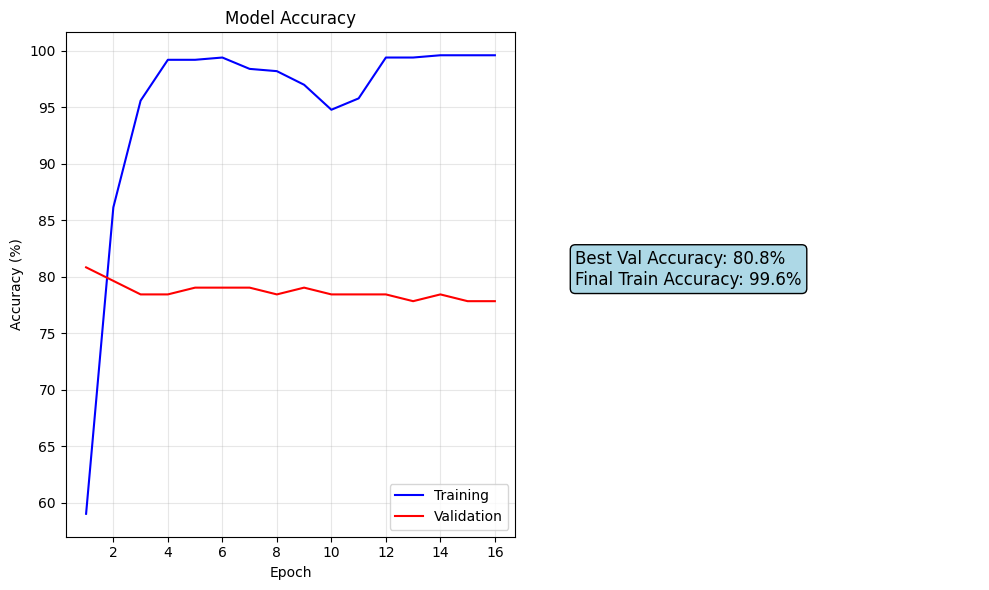


Pipeline Complete!
Final Test Accuracy: 79.0%
Training completed successfully!
Model saved as: best_heart_model.pth
Training plot saved as: training_results.png


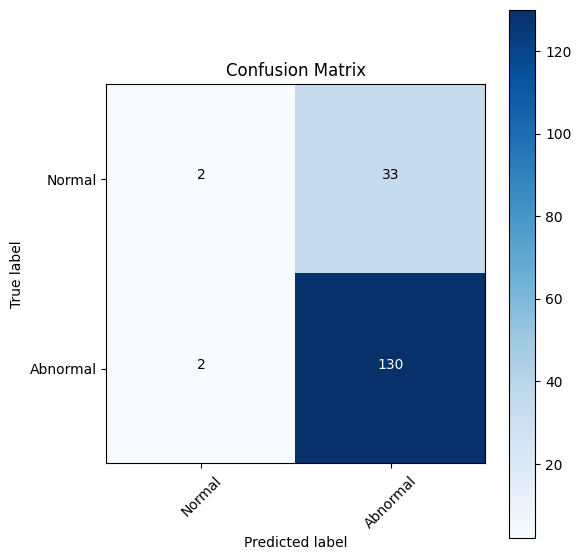


Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      0.06      0.10        35
    Abnormal       0.80      0.98      0.88       132

    accuracy                           0.79       167
   macro avg       0.65      0.52      0.49       167
weighted avg       0.74      0.79      0.72       167


Overall Accuracy: 79.04%
Normal Precision: 50.00%
Abnormal Recall: 98.48%
Loading audio data...
Found set_a and set_b directories
Loaded 832 audio samples
Normal: 176, Abnormal: 656


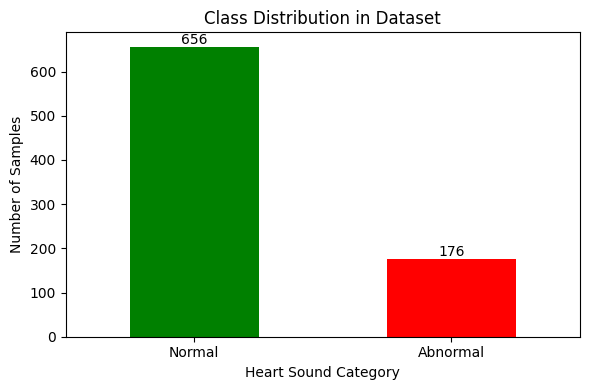

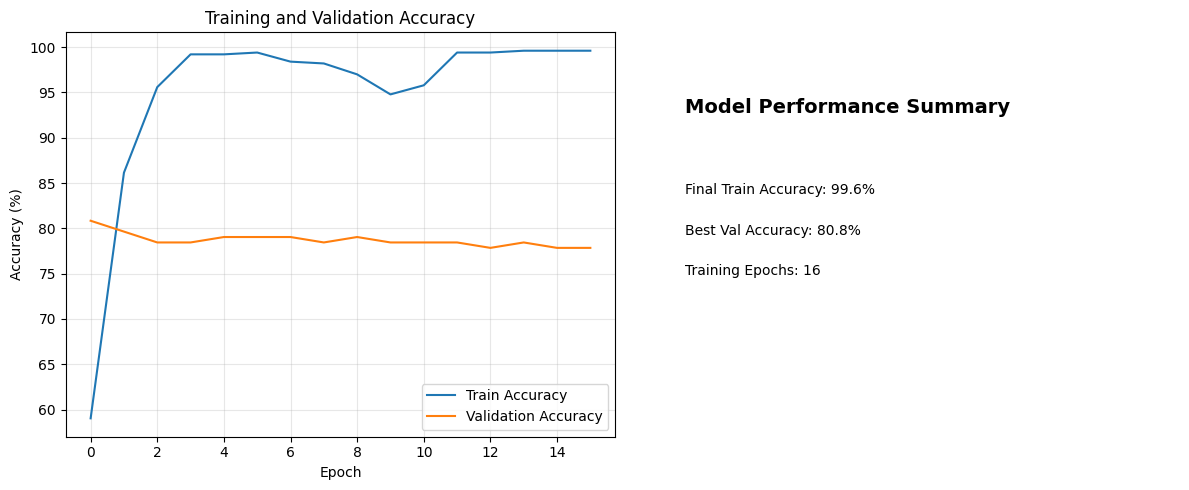

In [4]:
# Heart Sound Classification Pipeline using Kaggle Dataset
import kagglehub
import torch
import torchaudio
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class HeartSoundDataset(Dataset):
    def __init__(self, audio_data, labels):
        self.audio_data = audio_data
        self.labels = labels

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        audio = torch.FloatTensor(self.audio_data[idx])
        label = torch.LongTensor([self.labels[idx]])
        return audio, label

class HeartSoundClassifier(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(HeartSoundClassifier, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

class HeartSoundPipeline:
    def __init__(self, target_sample_rate=4000, segment_length=5.0):
        self.target_sample_rate = target_sample_rate
        self.segment_length = segment_length
        self.target_length = int(segment_length * target_sample_rate)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.dataset_path = None
        self.y_test = None # Store y_test here

        print(f"Using device: {self.device}")

    def download_dataset(self):
        print("Downloading dataset from Kaggle...")

        try:
            dataset_path = kagglehub.dataset_download("kinguistics/heartbeat-sounds")
            self.dataset_path = Path(dataset_path)
            print(f"Dataset downloaded to: {self.dataset_path}")

            # Show what we got
            for item in self.dataset_path.iterdir():
                if item.is_file():
                    print(f"   File: {item.name}")
                elif item.is_dir():
                    num_files = len(list(item.glob("*")))
                    print(f"   Folder: {item.name}/ ({num_files} files)")

            return True

        except Exception as e:
            print(f"Download failed: {e}")
            print("Make sure kagglehub is installed and you're authenticated with Kaggle")
            return False

    def load_data(self):
        if self.dataset_path is None:
            print("Dataset not downloaded. Call download_dataset() first.")
            return None, None, None

        print("Loading audio data...")

        audio_data = []
        labels = []
        filenames = []

        # Look for set_a (normal) and set_b (abnormal) directories
        set_a_path = self.dataset_path / "set_a"
        set_b_path = self.dataset_path / "set_b"

        if set_a_path.exists() and set_b_path.exists():
            print("Found set_a and set_b directories")

            # Load normal sounds
            for audio_file in set_a_path.glob("*.wav"):
                audio, label, filename = self._load_single_file(audio_file, 0)
                if audio is not None:
                    audio_data.append(audio)
                    labels.append(label)
                    filenames.append(filename)

            # Load abnormal sounds
            for audio_file in set_b_path.glob("*.wav"):
                audio, label, filename = self._load_single_file(audio_file, 1)
                if audio is not None:
                    audio_data.append(audio)
                    labels.append(label)
                    filenames.append(filename)

        else:
            # Fallback: scan for any wav files
            print("Scanning for wav files...")

            wav_files = list(self.dataset_path.rglob("*.wav"))

            for audio_file in wav_files:
                # Try to determine label from filename/path
                filename_lower = audio_file.name.lower()
                parent_lower = audio_file.parent.name.lower()

                if any(keyword in filename_lower for keyword in ['normal', 'healthy', 'set_a']):
                    label = 0
                elif any(keyword in filename_lower for keyword in ['abnormal', 'murmur', 'set_b']):
                    label = 1
                elif any(keyword in parent_lower for keyword in ['normal', 'healthy', 'set_a']):
                    label = 0
                elif any(keyword in parent_lower for keyword in ['abnormal', 'murmur', 'set_b']):
                    label = 1
                else:
                    # Random assignment for demo purposes
                    label = len(audio_data) % 2

                audio, label, filename = self._load_single_file(audio_file, label)
                if audio is not None:
                    audio_data.append(audio)
                    labels.append(label)
                    filenames.append(filename)

        audio_data = np.array(audio_data)
        labels = np.array(labels)

        print(f"Loaded {len(audio_data)} audio samples")
        print(f"Normal: {np.sum(labels == 0)}, Abnormal: {np.sum(labels == 1)}")

        return audio_data, labels, filenames

    def _load_single_file(self, audio_file, label):
        try:
            waveform, sample_rate = torchaudio.load(str(audio_file))
            processed_audio = self._preprocess_audio(waveform, sample_rate)
            return processed_audio, label, audio_file.name

        except Exception as e:
            print(f"Error loading {audio_file.name}: {e}")
            return None, None, None

    def _preprocess_audio(self, waveform, sample_rate):
        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if needed
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        # Fix length
        if waveform.shape[1] > self.target_length:
            start = (waveform.shape[1] - self.target_length) // 2
            waveform = waveform[:, start:start + self.target_length]
        elif waveform.shape[1] < self.target_length:
            padding = self.target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Normalize
        waveform = waveform / (torch.max(torch.abs(waveform)) + 1e-8)

        return waveform.squeeze().numpy()

    def create_data_splits(self, audio_data, labels, test_size=0.2, val_size=0.2):
        print("Creating data splits...")

        # First split: train+val vs test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            audio_data, labels, test_size=test_size,
            stratify=labels, random_state=42
        )

        # Second split: train vs val
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size/(1-test_size),
            stratify=y_train_val, random_state=42
        )
        self.y_test = y_test # Store y_test

        print(f"Training: {len(X_train)} samples")
        print(f"Validation: {len(X_val)} samples")
        print(f"Test: {len(X_test)} samples")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def train_model(self, train_data, val_data, epochs=50, batch_size=32, learning_rate=0.001):
        X_train, y_train = train_data
        X_val, y_val = val_data

        print("\nTraining model...")

        # Create data loaders
        train_dataset = HeartSoundDataset(X_train, y_train)
        val_dataset = HeartSoundDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_size = X_train.shape[1]
        self.model = HeartSoundClassifier(input_size=input_size).to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.5)

        history = {'train_acc': [], 'val_acc': []}
        best_val_acc = 0.0
        patience_counter = 0
        patience = 15

        print(f"Training for {epochs} epochs...")

        for epoch in range(epochs):
            # Training
            self.model.train()
            train_correct = 0
            train_total = 0
            train_loss = 0.0

            for batch_audio, batch_labels in train_loader:
                batch_audio = batch_audio.to(self.device)
                batch_labels = batch_labels.squeeze().to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_audio)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_labels.size(0)
                train_correct += (predicted == batch_labels).sum().item()

            # Validation
            self.model.eval()
            val_correct = 0
            val_total = 0
            val_loss = 0.0

            with torch.no_grad():
                for batch_audio, batch_labels in val_loader:
                    batch_audio = batch_audio.to(self.device)
                    batch_labels = batch_labels.squeeze().to(self.device)

                    outputs = self.model(batch_audio)
                    loss = criterion(outputs, batch_labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_labels.size(0)
                    val_correct += (predicted == batch_labels).sum().item()

            train_acc = 100 * train_correct / train_total
            val_acc = 100 * val_correct / val_total

            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            scheduler.step(val_loss / len(val_loader))

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'best_val_acc': best_val_acc,
                }, 'best_heart_model.pth')
            else:
                patience_counter += 1

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch+1:3d}/{epochs} | Train Acc: {train_acc:5.1f}% | Val Acc: {val_acc:5.1f}%')

            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Best validation accuracy: {best_val_acc:.1f}%")
        return history

    def evaluate_model(self, test_data):
        X_test, y_test = test_data

        print("\nEvaluating model...")

        if self.model is None:
            print("No trained model found!")
            return None

        # Load best model
        try:
            checkpoint = torch.load('best_heart_model.pth')
            self.model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded best model")
        except:
            print("Using current model weights")

        self.model.eval()

        test_dataset = HeartSoundDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch_audio, batch_labels in test_loader:
                batch_audio = batch_audio.to(self.device)
                batch_labels = batch_labels.squeeze().to(self.device)

                outputs = self.model(batch_audio)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        cm = confusion_matrix(all_labels, all_predictions)

        print(f"Test Accuracy: {accuracy*100:.1f}%")

        return {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'predictions': all_predictions
        }

    def plot_training_history(self, history):
        if len(history['train_acc']) == 0:
            return

        plt.figure(figsize=(10, 6))

        epochs = range(1, len(history['train_acc']) + 1)

        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_acc'], 'b-', label='Training')
        plt.plot(epochs, history['val_acc'], 'r-', label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.text(0.1, 0.5, f'Best Val Accuracy: {max(history["val_acc"]):.1f}%\n'
                            f'Final Train Accuracy: {history["train_acc"][-1]:.1f}%',
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('training_results.png', dpi=150)
        plt.show()

    def predict_single_file(self, audio_file_path):
        if self.model is None:
            print("No trained model found!")
            return None

        try:
            waveform, sample_rate = torchaudio.load(audio_file_path)
            processed_audio = self._preprocess_audio(waveform, sample_rate)

            audio_tensor = torch.FloatTensor(processed_audio).unsqueeze(0).to(self.device)

            self.model.eval()
            with torch.no_grad():
                output = self.model(audio_tensor)
                probability = torch.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)

            prediction = predicted.item()
            confidence = probability[0][prediction].item()

            result = {
                'prediction': 'Normal' if prediction == 0 else 'Abnormal',
                'confidence': confidence
            }

            return result

        except Exception as e:
            print(f"Error predicting on {audio_file_path}: {e}")
            return None

    def run_complete_pipeline(self, epochs=50):
        print("Heart Sound Classification Pipeline")
        print("Dataset: Heartbeat Sounds from Kaggle")
        print("-" * 40)

        try:
            # Download dataset
            if not self.download_dataset():
                return None

            # Load data
            audio_data, labels, filenames = self.load_data()
            if audio_data is None:
                return None

            # Create splits
            train_data, val_data, test_data = self.create_data_splits(audio_data, labels)

            # Train model
            history = self.train_model(train_data, val_data, epochs=epochs)

            # Evaluate model
            eval_results = self.evaluate_model(test_data)

            # Plot results
            self.plot_training_history(history)

            print(f"\nPipeline Complete!")
            print(f"Final Test Accuracy: {eval_results['accuracy']*100:.1f}%")

            return {
                'history': history,
                'results': eval_results,
                'model': self.model
            }

        except Exception as e:
            print(f"Pipeline failed: {str(e)}")
            return None

# Main execution
if __name__ == "__main__":
    print("Heart Sound Classification")
    print("Using Kaggle dataset: kinguistics/heartbeat-sounds")
    print()

    # Initialize pipeline
    pipeline = HeartSoundPipeline(target_sample_rate=4000, segment_length=5.0)

    # Run complete pipeline
    results = pipeline.run_complete_pipeline(epochs=50)

    if results:
        print("Training completed successfully!")
        print("Model saved as: best_heart_model.pth")
        print("Training plot saved as: training_results.png")

    else:
        print("Training failed. Check error messages above.")
        print("\nSetup instructions:")
        print("1. Install: pip install kagglehub")
        print("2. Get Kaggle API key from kaggle.com/account")
        print("3. Place kaggle.json in ~/.kaggle/")

def load_trained_model(model_path='best_heart_model.pth', input_size=20000):
    """Load a previously trained model"""
    try:
        checkpoint = torch.load(model_path)
        model = HeartSoundClassifier(input_size=input_size)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        print(f"Loaded model with {checkpoint['best_val_acc']:.1f}% validation accuracy")
        return model

    except Exception as e:
        print(f"Failed to load model: {e}")
        return None


def plot_confusion_matrix(cm, classes=['Normal', 'Abnormal']):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=120)
    plt.show()

# Example usage:
if results:
    cm = results['results']['confusion_matrix']
    plot_confusion_matrix(cm)

    from sklearn.metrics import classification_report, precision_score, recall_score

    def print_metrics(y_true, y_pred):
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))

        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nOverall Accuracy: {accuracy:.2%}")
        print(f"Normal Precision: {precision_score(y_true, y_pred, pos_label=0, zero_division=0):.2%}")
        print(f"Abnormal Recall: {recall_score(y_true, y_pred, pos_label=1, zero_division=0):.2%}")

    # Example usage:
    # Make sure pipeline object is available to access y_test
    if 'pipeline' in locals() and pipeline.y_test is not None:
        print_metrics(pipeline.y_test, results['results']['predictions'])
    else:
        print("Could not access y_test for detailed metrics. Run the pipeline first.")

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig('roc_curve.png', dpi=120)
    plt.show()

def plot_class_distribution(labels):
    class_counts = pd.Series(labels).value_counts()
    class_counts.index = ['Normal', 'Abnormal']

    plt.figure(figsize=(6, 4))
    class_counts.plot(kind='bar', color=['green', 'red'])
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Heart Sound Category')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=0)

    for i, count in enumerate(class_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=120)
    plt.show()

# Example usage:
_, labels, _ = pipeline.load_data()
plot_class_distribution(labels)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Metrics summary
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.1, 0.8, 'Model Performance Summary', fontsize=14, fontweight='bold')
    plt.text(0.1, 0.6, f"Final Train Accuracy: {history['train_acc'][-1]:.1f}%")
    plt.text(0.1, 0.5, f"Best Val Accuracy: {max(history['val_acc']):.1f}%")
    plt.text(0.1, 0.4, f"Training Epochs: {len(history['train_acc'])}")

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=120, bbox_inches='tight')
    plt.show()

# Example usage after training:
plot_training_history(results['history'])
